<a href="https://colab.research.google.com/github/kimmjen/bit_project/blob/master/%ED%94%84%EB%A1%9C%EC%A0%9D%ED%8A%B8%EC%B5%9C%EC%A2%85.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
ls


In [0]:
cd /content/drive/My Drive/Colab Notebooks

In [0]:
ls


2. 데이터 분석해보기

만들어진 csv파일을 google drive에 업로드하고 google colab에서 google drive를 마운트한 뒤 진행했습니다.


In [0]:
import pandas as pd 

train_data = pd.read_csv("/content/drive/My Drive/Colab Notebooks/data/train_sum_ibk.csv") 
test_data = pd.read_csv("/content/drive/My Drive/Colab Notebooks/data/test_sum_ibk.csv")


In [0]:
train_data

In [0]:
test_data

train_data와 test_data를 pandas의 read_csv를 활용하여 dataframe으로 불러옵니다.

 

그 다음 matplotlib을 활용하여 0, 1 라벨별로 각각 몇개의 데이터가 존재하는지 확인해봅니다.


In [0]:
%matplotlib inline 
import matplotlib.pyplot as plt


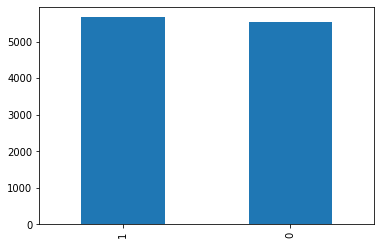

In [0]:
# train_data['label'].value_counts().plot(kind='bar')

train_data['up/down'].value_counts().plot(kind='bar')

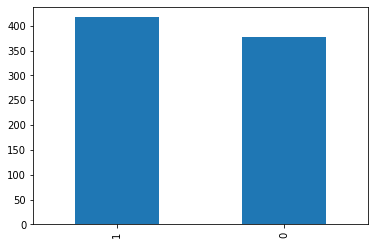

In [0]:
# test_data['label'].value_counts().plot(kind='bar')

test_data['up/down'].value_counts().plot(kind='bar')


숫자로도 확인해봅니다. 1이 상승 0이 하락

In [0]:
# print(train_data.groupby('label').size().reset_index(name='count')) print(test_data.groupby('label').size().reset_index(name='count'))

print(train_data.groupby('up/down').size().reset_index(name='count')) 
print(test_data.groupby('up/down').size().reset_index(name='count'))


   up/down  count
0        0   5542
1        1   5663
   up/down  count
0        0    378
1        1    417


# 3. 모델을 만들기 위한 데이터 전처리 작업
먼저 각각의 제목을 토큰화 해주었습니다.

Okt형태소 분석기를 활용하였습니다.


In [0]:
stopwords = ['의', '가', '이', '은', '들', '는', '좀', '잘', '걍', '과', '도', '를', '으로', '자', '에', '와', '한', '하다', '[Hot-Line]', '[시장을 이겨라]', '[단독]']


In [0]:
pip install konlpy

In [0]:
import konlpy 
from konlpy.tag import Okt 
# from konlpy.tag import Kkma 
# kkma = Kkma() 
okt = Okt()
X_train = [] 
for sentence in train_data['headline']: 
  temp_X = [] 
  # temp_X = kkma.morphs(sentence, stem=True) # 토큰화 
  temp_X = kkma.morphs(sentence) # 토큰화 
  
  temp_X = [word for word in temp_X if not word in stopwords] # 불용어 제거 
  temp_X
  X_train.append(temp_X) 

X_test = [] 
  
for sentence in test_data['headline']: 
  temp_X = [] 
  # temp_X = kkma.morphs(sentence, stem=True) # 토큰화 
  temp_X = kkma.morphs(sentence) # 토큰화 
  temp_X = [word for word in temp_X if not word in stopwords] # 불용어 제거 
  X_test.append(temp_X)


In [0]:
# temp_X
X_train
# 트레인과 테스트 똑같이!


In [0]:
X_test

In [0]:
from keras.preprocessing.text import Tokenizer 

max_words = 5000 
# max_words = 35000 
tokenizer = Tokenizer(num_words = max_words) 
tokenizer.fit_on_texts(X_train)

X_train = tokenizer.texts_to_sequences(X_train) 
X_test = tokenizer.texts_to_sequences(X_test)


In [0]:
print("제목의 최대 길이 : ", max(len(l) for l in X_train)) 
print("제목의 평균 길이 : ", sum(map(len, X_train))/ len(X_train)) 
plt.hist([len(s) for s in X_train], bins=50) 
plt.xlabel('length of Data') 
plt.ylabel('number of Data') 
plt.show()


In [0]:
print("제목의 최대 길이 : ", max(len(l) for l in X_test)) 
print("제목의 평균 길이 : ", sum(map(len, X_test))/ len(X_test)) 
plt.hist([len(s) for s in X_test], bins=50) 
plt.xlabel('length of Data') 
plt.ylabel('number of Data') 
plt.show()


다음으로는 y값으로 들어갈 label  0, 1을 컴퓨터가 보고 알수 있도록 one-hot encoding을 해주었습니다.

> 들여쓴 블록




In [0]:
import numpy as np 

y_train = [] 
y_test = [] 

for i in range(len(train_data['up/down'])): 
  if train_data['up/down'].iloc[i] == 1: 
    y_train.append([0, 1]) 
  elif train_data['up/down'].iloc[i] == 0: 
    y_train.append([1, 0]) 

    
for i in range(len(test_data['up/down'])): 
  if test_data['up/down'].iloc[i] == 1: 
    y_test.append([0, 1]) 
  elif test_data['up/down'].iloc[i] == 0: 
    y_test.append([1, 0]) 

y_train = np.array(y_train) 
y_test = np.array(y_test)


# 4. 모델 만들기

In [0]:
from keras.layers import Embedding, Dense, LSTM 
from keras.models import Sequential 
from keras.preprocessing.sequence import pad_sequences 

# max_len = 20 # 전체 데이터의 길이를 20로 맞춘다 
max_len = 20

X_train = pad_sequences(X_train, maxlen=max_len) 

X_test = pad_sequences(X_test, maxlen=max_len)

model = Sequential() 
model.add(Embedding(max_words, 100)) 
model.add(LSTM(128)) 
model.add(Dense(2, activation='softmax')) 

model.compile(optimizer='rmsprop', loss='categorical_crossentropy', metrics=['accuracy']) 

history = model.fit(X_train, y_train, epochs=10, batch_size=10, validation_split=0.1)


In [0]:
from keras.layers import Embedding, Dense, LSTM 
from keras.models import Sequential 
from keras.preprocessing.sequence import pad_sequences 

# max_len = 20 # 전체 데이터의 길이를 20로 맞춘다 
max_len = 20

X_train = pad_sequences(X_train, maxlen=max_len) 

X_test = pad_sequences(X_test, maxlen=max_len)

model = Sequential() 
model.add(Embedding(max_words, 100)) 
model.add(LSTM(128)) 
model.add(Dense(1, activation='sigmoid')) 

model.compile(optimizer='rmsprop', loss='categorical_crossentropy', metrics=['accuracy']) 

history = model.fit(X_train, y_train, epochs=10, batch_size=10, validation_split=0.1)


In [0]:
model.summary()


먼저 필요한 것들을 import 해주고 pad_sequences를 활용하여 모든 데이터의 길이를 20,40으로 통일하였습니다.




In [0]:
print("\n 테스트 정확도 : {:2f}%".format(model.evaluate(X_test, y_test)[1]*100))

In [0]:
from keras.layers import Embedding, Dense, LSTM 
from keras.models import Sequential 
from keras.preprocessing.sequence import pad_sequences 

max_len = 20 # 전체 데이터의 길이를 20로 맞춘다 

X_train = pad_sequences(X_train, maxlen=max_len) 
X_test = pad_sequences(X_test, maxlen=max_len)


In [0]:
model2 = Sequential() 
model2.add(Embedding(max_words, 100)) 
model2.add(LSTM(128)) 
model2.add(Dense(2, activation='softmax')) 

model2.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy']) 

history = model2.fit(X_train, y_train, epochs=10, batch_size=100, validation_split=0.1)


In [0]:
print("\n 테스트 정확도 : {:2f}%".format(model.evaluate(X_test, y_test)[1]*100))

In [0]:
from keras.layers import Embedding, Dense, LSTM 
from keras.models import Sequential 
from keras.preprocessing.sequence import pad_sequences 

# max_len = 20 # 전체 데이터의 길이를 20로 맞춘다 
max_len = 20

X_train = pad_sequences(X_train, maxlen=max_len) 
X_test = pad_sequences(X_test, maxlen=max_len)
model3 = Sequential() 
model3.add(Embedding(max_words, 100)) 
model3.add(LSTM(128)) 
model3.add(Dense(2, activation='softmax')) 

model3.compile(optimizer='rmsprop', loss='categorical_crossentropy', metrics=['accuracy']) 

history = model3.fit(X_train, y_train, epochs=10, batch_size=10, validation_split=0.05)


Using TensorFlow backend.


NameError: ignored

In [0]:
print("\n 테스트 정확도 : {:2f}%".format(model3.evaluate(X_test, y_test)[1]*100))

In [0]:
from keras.layers import Embedding, Dense, LSTM 
from keras.models import Sequential 
from keras.preprocessing.sequence import pad_sequences 

# max_len = 20 # 전체 데이터의 길이를 20로 맞춘다 
max_len = 20

X_train = pad_sequences(X_train, maxlen=max_len) 
X_test = pad_sequences(X_test, maxlen=max_len)
model4 = Sequential() 
model4.add(Embedding(max_words, 100)) 
model4.add(LSTM(128)) 
model4.add(Dense(2, activation='softmax')) 

model4.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy']) 

history = model4.fit(X_train, y_train, epochs=10, batch_size=10, validation_split=0.05)


In [0]:
print("\n 테스트 정확도 : {:2f}%".format(model4.evaluate(X_test, y_test)[1]*100))

In [0]:
from keras.layers import Embedding, Dense, LSTM 
from keras.models import Sequential 
from keras.preprocessing.sequence import pad_sequences 

# max_len = 20 # 전체 데이터의 길이를 20로 맞춘다 
max_len = 40

X_train = pad_sequences(X_train, maxlen=max_len) 
X_test = pad_sequences(X_test, maxlen=max_len)
model5 = Sequential() 
model5.add(Embedding(max_words, 100)) 
model5.add(LSTM(128)) 
model5.add(Dense(2, activation='softmax')) 
model5.compile(optimizer='rmsprop', loss='categorical_crossentropy', metrics=['accuracy']) 

history = model5.fit(X_train, y_train, epochs=10, batch_size=10, validation_split=0.05)


In [0]:
print("\n 테스트 정확도 : {:2f}%".format(model5.evaluate(X_test, y_test)[1]*100))

In [0]:
from keras.layers import Embedding, Dense, LSTM 
from keras.models import Sequential 
from keras.preprocessing.sequence import pad_sequences 

# max_len = 20 # 전체 데이터의 길이를 20로 맞춘다 
max_len = 40

X_train = pad_sequences(X_train, maxlen=max_len) 
X_test = pad_sequences(X_test, maxlen=max_len)
model6 = Sequential() 
model6.add(Embedding(max_words, 100)) 
model6.add(LSTM(128)) 
model6.add(Dense(2, activation='softmax')) 
model6.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy']) 

history = model6.fit(X_train, y_train, epochs=10, batch_size=10, validation_split=0.05)


In [0]:
print("\n 테스트 정확도 : {:2f}%".format(model6.evaluate(X_test, y_test)[1]*100))

In [0]:
from keras.layers import Embedding, Dense, LSTM 
from keras.models import Sequential 
from keras.preprocessing.sequence import pad_sequences 

# max_len = 20 # 전체 데이터의 길이를 20로 맞춘다 
max_len = 40

X_train = pad_sequences(X_train, maxlen=max_len) 
X_test = pad_sequences(X_test, maxlen=max_len)
model6 = Sequential() 
model6.add(Embedding(max_words, 100)) 
model6.add(LSTM(128)) 
model6.add(Dense(2, activation='softmax')) 
model6.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy']) 

history = model6.fit(X_train, y_train, epochs=10, batch_size=10, validation_split=0.05)


상승, 하락 2가지로 분류해야하니 
LSTM, softmax, categorical_crossentropy를 사용하였습니다.

batch_size는 10084개의 훈련데이터 중 10퍼센트인 1008.4개는 validation_data로 활용하기위해 validation_split을 0.1을 부여하였습니다.

optimizer는 rmsprop을 사용하여 위와 같이 모델을 만들고 학습을 시켜보았습니다.


In [0]:
predict = model.predict(X_test)


In [0]:
import numpy as np 

predict_labels = np.argmax(predict, axis=1) 
original_labels = np.argmax(y_test, axis=1)


In [0]:
for i in range(100): 
  print("기사제목 : ", test_data['headline'].iloc[i], "/\t 실제 방향 : ", original_labels[i], "/\t예측 방향 : ", predict_labels[i])
